In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import itertools
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation

In [2]:
df=pd.read_csv('product b.csv', parse_dates=['Month-Year'])

In [3]:
sales_b= df.drop(['Product Name','Product Category','Month','Year','Market Size', 'Marketing Expense','Month No.'],axis=1)

In [4]:
sales_b.shape

(60, 2)

In [5]:
sales_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month-Year  60 non-null     datetime64[ns]
 1   Sales       60 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.1 KB


In [6]:
sales_b['Sales'].sum()

70016882

In [7]:
sales_b = sales_b.rename(columns={'Month-Year': 'ds',
                        'Sales': 'y'})

sales_b.head(5)

ds        y
0 2019-01-01   494357
1 2019-02-01   837207
2 2019-03-01  1278271
3 2019-04-01   675985
4 2019-05-01   757687

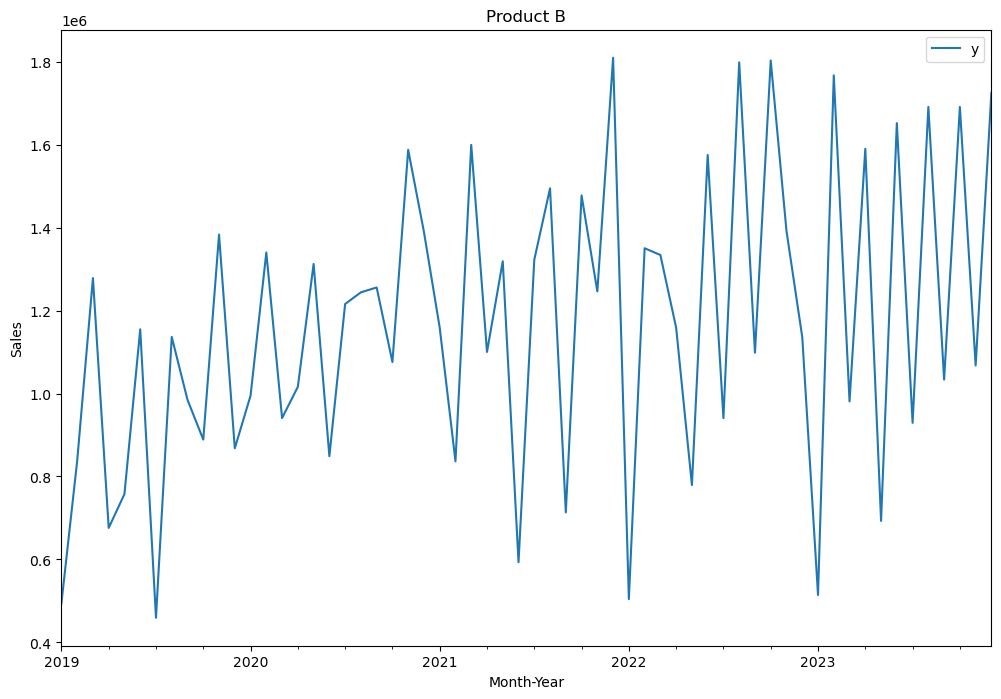

In [8]:
ax = sales_b.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Sales')
ax.set_xlabel('Month-Year')
plt.title('Product B')
plt.show()

In [9]:
train= sales_b[:57]
test=sales_b[57:]

# Hyperparameter Tuning

In [10]:
changepoint_prior_scale_range = [0.001, 0.01, 0.1,0.2, 0.3, 0.5]
seasonality_prior_scale_range = [0.01, 0.1, 1.0, 3.0, 5.0, 10.0]
seasonality_mode_range = ['additive', 'multiplicative']

param_grid = {  
    'changepoint_prior_scale': changepoint_prior_scale_range,
    'seasonality_prior_scale': seasonality_prior_scale_range,
    'seasonality_mode' : seasonality_mode_range
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train)  # Fit model with given params
    df_cv = cross_validation(m, initial='730 days', period='90 days', horizon = '90 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

14:09:01 - cmdstanpy - INFO - Chain [1] start processing
14:09:02 - cmdstanpy - INFO - Chain [1] done processing
14:09:07 - cmdstanpy - INFO - Chain [1] start processing
14:09:07 - cmdstanpy - INFO - Chain [1] done processing
14:09:19 - cmdstanpy - INFO - Chain [1] start processing
14:09:19 - cmdstanpy - INFO - Chain [1] done processing
14:09:25 - cmdstanpy - INFO - Chain [1] start processing
14:09:35 - cmdstanpy - INFO - Chain [1] done processing
14:09:41 - cmdstanpy - INFO - Chain [1] start processing
14:09:41 - cmdstanpy - INFO - Chain [1] done processing
14:10:08 - cmdstanpy - INFO - Chain [1] start processing
14:10:08 - cmdstanpy - INFO - Chain [1] done processing
14:10:18 - cmdstanpy - INFO - Chain [1] start processing
14:10:18 - cmdstanpy - INFO - Chain [1] done processing
14:10:26 - cmdstanpy - INFO - Chain [1] start processing
14:10:30 - cmdstanpy - INFO - Chain [1] done processing
14:10:35 - cmdstanpy - INFO - Chain [1] start processing
14:10:35 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
0                     0.001                     0.01         additive   
1                     0.001                     0.01   multiplicative   
2                     0.001                     0.10         additive   
3                     0.001                     0.10   multiplicative   
4                     0.001                     1.00         additive   
..                      ...                      ...              ...   
67                    0.500                     3.00   multiplicative   
68                    0.500                     5.00         additive   
69                    0.500                     5.00   multiplicative   
70                    0.500                    10.00         additive   
71                    0.500                    10.00   multiplicative   

             rmse  
0   417141.520824  
1   421795.580125  
2   397409.780342  
3   408110.636709  
4   376645.988642  
.. 

In [11]:
tuning_results.sort_values('rmse',ascending=True)

changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
71                    0.500                    10.00   multiplicative   
69                    0.500                     5.00   multiplicative   
9                     0.001                     5.00   multiplicative   
67                    0.500                     3.00   multiplicative   
34                    0.100                    10.00         additive   
..                      ...                      ...              ...   
13                    0.010                     0.01   multiplicative   
60                    0.500                     0.01         additive   
49                    0.300                     0.01   multiplicative   
1                     0.001                     0.01   multiplicative   
61                    0.500                     0.01   multiplicative   

             rmse  
71  366118.138989  
69  366307.559382  
9   366551.898786  
67  367017.762771  
34  367674.835442  
..            ...  
13  419552.185391  
60  420561.256304  
49  420863.397578  
1   421795.580125  
61  422038.349192  

[72 rows x 4 columns]

In [12]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}


In [13]:
# Create a Prophet model
#model = Prophet(changepoint_prior_scale=0.0100, seasonality_prior_scale=4.006, interval_width=0.95)
model = Prophet(changepoint_prior_scale=0.500, seasonality_prior_scale=10.00,seasonality_mode = 'multiplicative',
                interval_width=0.95)

In [14]:
model.fit(train)

14:16:03 - cmdstanpy - INFO - Chain [1] start processing
14:16:04 - cmdstanpy - INFO - Chain [1] done processing


In [15]:
len(test)

3

In [18]:
# Create a DataFrame for future dates (including 2023)
future_dates = model.make_future_dataframe(periods=len(test), freq='MS')  # 3 months in 2023

In [19]:
# Make predictions for the future
forecast = model.predict(future_dates)

In [20]:
forecasted_df=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(3)

In [21]:
forecasted_df

ds          yhat    yhat_lower    yhat_upper
57 2023-10-01  1.673598e+06  1.290031e+06  2.068921e+06
58 2023-11-01  1.608795e+06  1.178055e+06  2.004417e+06
59 2023-12-01  1.153122e+06  7.494212e+05  1.574416e+06

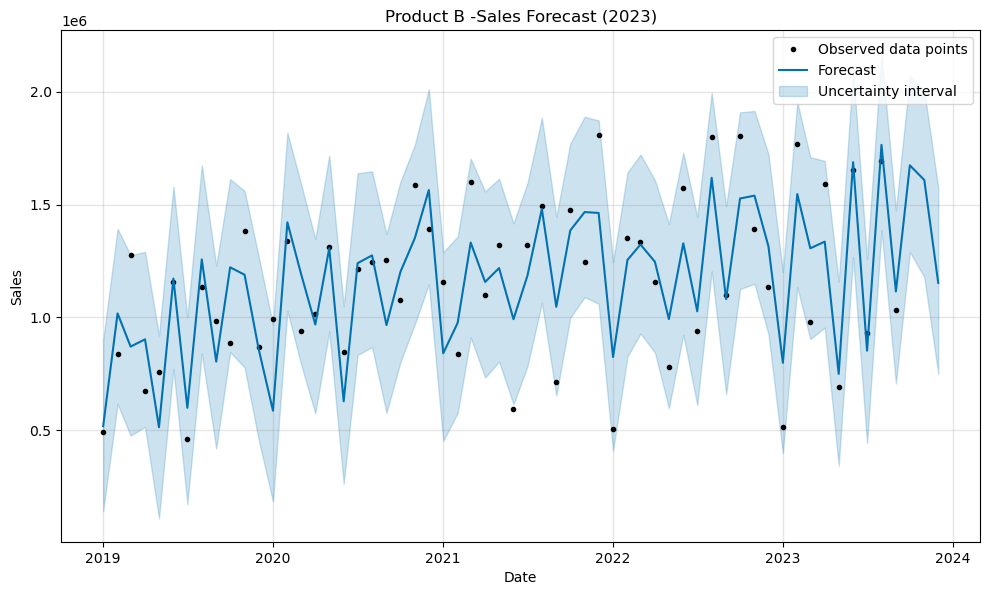

In [22]:
fig = model.plot(forecast, include_legend=True, uncertainty=True)
plt.title('Product B -Sales Forecast (2023)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

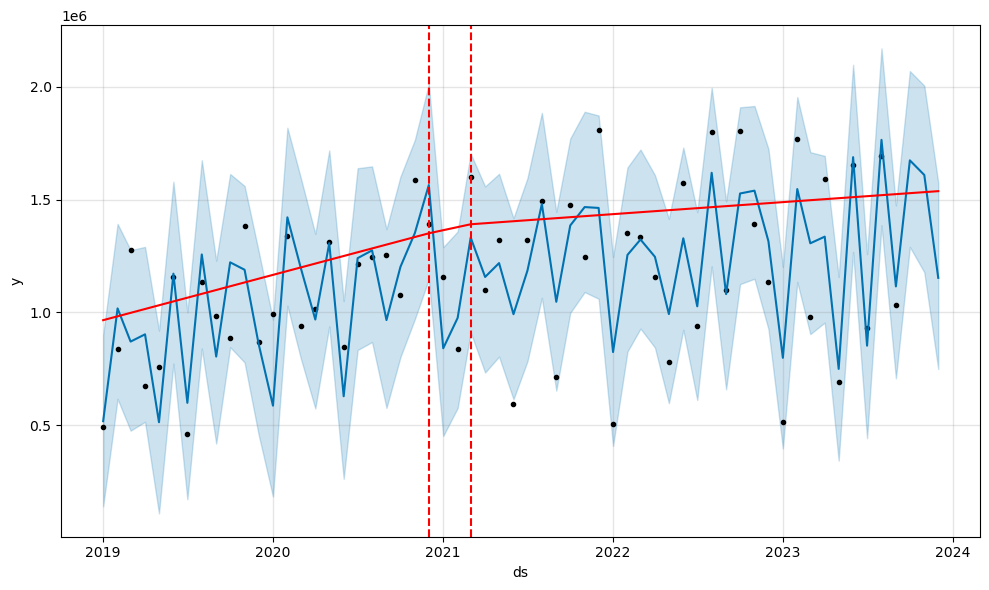

In [45]:
from prophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

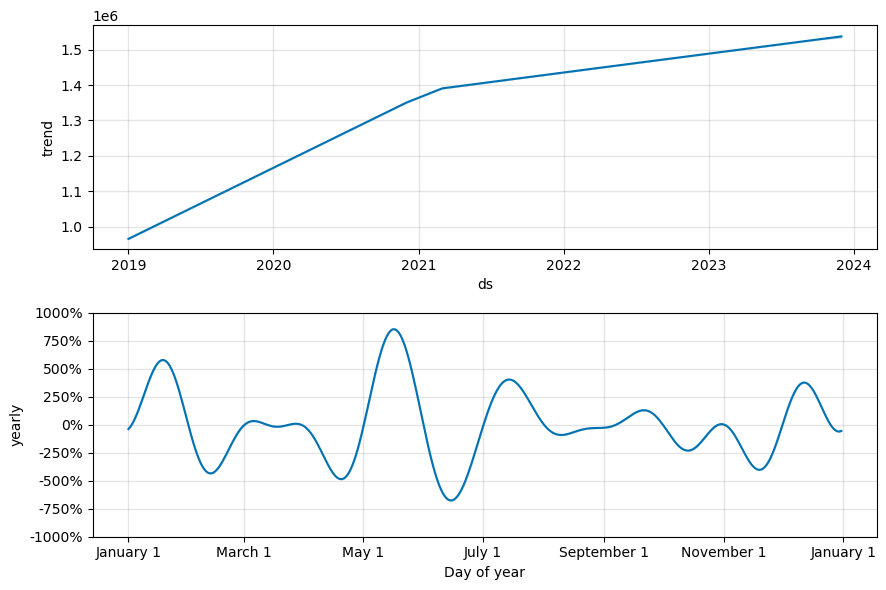

In [24]:
fig2 = model.plot_components(forecast)

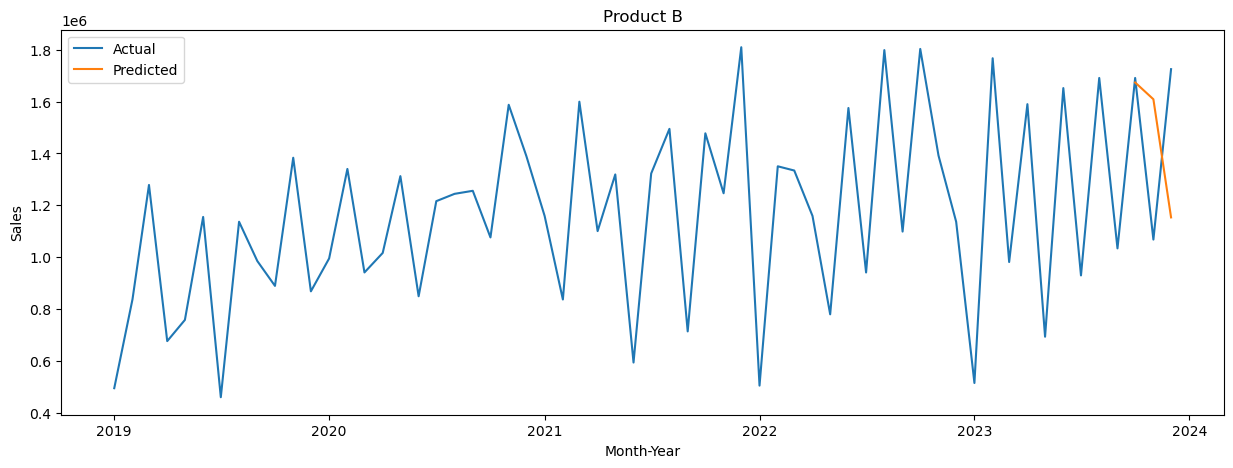

In [25]:
# Reset index of sales_b DataFrame
sales_b_reset_index = sales_b.reset_index()

# Plotting
plt.figure(figsize=(15, 5))
plt.plot(sales_b_reset_index['ds'], sales_b_reset_index['y'], label='Actual')
plt.plot(forecasted_df['ds'], forecasted_df['yhat'], label='Predicted')
plt.title('Product B')
plt.xlabel('Month-Year')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [26]:
#model evaluation

In [27]:
pred=forecasted_df['yhat']
test_df=test['y']

In [28]:
mae_fb= mean_absolute_error(test_df,pred)
mse_fb=mean_squared_error(test_df, pred)
mape_fb= mean_absolute_percentage_error(test_df,pred)
rmse_fb= np.sqrt(mean_squared_error(test_df,pred))


print(f'MAE - FB PROPHET: {mae_fb:.3f}')
print(f'MAPE - FB PROPHET: {mape_fb:.3f}')
print(f'MSE - FB PROPHET: {mse_fb:.3f}')
print(f'RMSE - FB PROPHET: {rmse_fb:.3f}')

MAE - FB PROPHET: 376785.192
MAPE - FB PROPHET: 0.283
MSE - FB PROPHET: 206720354605.276
RMSE - FB PROPHET: 454665.102


In [29]:
# train data: 0 to 47 --> Jan-2019 to Dec-2022
# test data: 48: 59 --> Jan 2023 to Dec-2023

#sales_b['y'].plot(figsize=(12,8))
#forecast_df['yhat'].plot()
#plt.title('Product B')
#plt.xlabel('Month')
#plt.ylabel('Sales')
#plt.legend(labels=['Actual', 'Predicted'])
#plt.show()

In [30]:
#Set initial window to 2 years (24 months), period to 1 year (12 months), and horizon to 1 year (12 months)
df_cv = cross_validation(model, initial='730 days', period='90 days', horizon='90 days', parallel="processes")

In [31]:
df_p = performance_metrics(df_cv)
df_p

horizon           mse           rmse            mae      mape     mdape  \
0  20 days  1.002626e+11  316642.694280  276707.858279  0.201297  0.259225   
1  22 days  2.238938e+11  473174.198258  427863.349348  0.595949  0.286472   
2  23 days  1.660176e+11  407452.609673  311558.234665  0.526807  0.157693   
3  25 days  1.512239e+11  388875.145143  317942.022645  0.359650  0.249218   
4  27 days  2.174795e+11  466346.986160  464695.816438  0.468014  0.326133   
5  28 days  1.583898e+11  397982.106838  367218.954993  0.441211  0.326133   
6  47 days  8.658927e+10  294260.553256  242884.610958  0.273860  0.168810   
7  49 days  3.286104e+10  181276.134955  169811.345696  0.137850  0.168810   
8  51 days  6.230595e+10  249611.595195  229542.664151  0.171474  0.169381   
9  52 days  1.081187e+11  328814.020886  324353.368275  0.310523  0.269684   
10 53 days  9.798659e+10  313028.091297  301153.931349  0.299380  0.269684   
11 54 days  7.775436e+10  278844.687658  265322.924744  0.251852  0.135953   
12 56 days  5.067001e+10  225100.009158  223059.315517  0.149243  0.135953   
13 57 days  4.750424e+10  217954.676292  213724.471715  0.178762  0.184675   
14 58 days  6.491952e+10  254793.096679  245283.060257  0.197375  0.184675   
15 59 days  5.240253e+10  228915.981827  215892.133244  0.169102  0.182938   
16 78 days  1.824983e+11  427198.161549  378639.457477  0.455970  0.182938   
17 80 days  2.147245e+11  463383.762426  420395.070392  0.604553  0.628688   
18 81 days  2.185117e+11  467452.364671  461255.486612  0.406496  0.309402   
19 83 days  2.118253e+11  460244.782726  453605.962476  0.286996  0.281396   
20 85 days  1.372092e+11  370417.553199  316973.879569  0.206047  0.270189   
21 86 days  2.053038e+11  453104.648057  359945.276490  0.350950  0.262854   
22 88 days  2.059505e+11  453817.721851  364907.127067  0.348084  0.262854   
23 90 days  1.137244e+11  337230.523858  251915.118293  0.236862  0.166483   

       smape  coverage  
0   0.229580  0.333333  
1   0.436423  0.333333  
2   0.350315  0.666667  
3   0.282729  0.500000  
4   0.420096  0.000000  
5   0.386656  0.333333  
6   0.248264  0.666667  
7   0.147349  0.666667  
8   0.165105  0.333333  
9   0.272627  0.000000  
10  0.259566  0.333333  
11  0.225594  0.666667  
12  0.150220  1.000000  
13  0.168881  1.000000  
14  0.190757  1.000000  
15  0.166105  1.000000  
16  0.333305  0.666667  
17  0.425630  0.333333  
18  0.363681  0.000000  
19  0.308369  0.000000  
20  0.223318  0.333333  
21  0.274103  0.666667  
22  0.271371  0.666667  
23  0.194084  0.833333

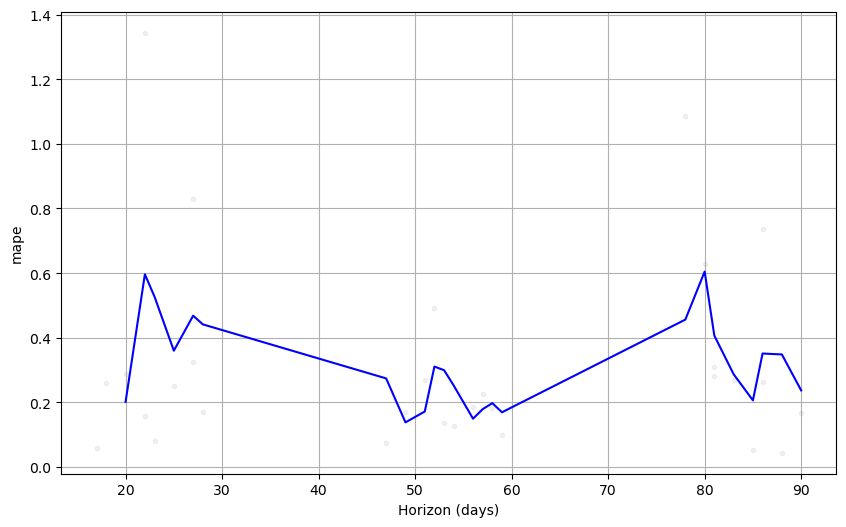

In [32]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [33]:
test_df

57    1690948
58    1067615
59    1724948
Name: y, dtype: int64

In [34]:
pred

57    1.673598e+06
58    1.608795e+06
59    1.153122e+06
Name: yhat, dtype: float64

# FORECASTING

In [35]:
model_forecast = Prophet(changepoint_prior_scale=0.500, seasonality_prior_scale=10.00,seasonality_mode = 'multiplicative',
                interval_width=0.95)

In [36]:
model_forecast.fit(sales_b)

14:17:14 - cmdstanpy - INFO - Chain [1] start processing
14:17:15 - cmdstanpy - INFO - Chain [1] done processing


In [37]:
# Create a DataFrame for future dates 
future_dates_f = model_forecast.make_future_dataframe(periods=3, freq='MS')  # 3 months in 2024

In [38]:
# Make predictions for the future
forecast_f = model_forecast.predict(future_dates_f)

In [39]:
forecasted_f_df=forecast_f[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(3)

In [40]:
forecasted_f_df

ds          yhat    yhat_lower    yhat_upper
60 2024-01-01  7.673671e+05  3.887498e+05  1.165973e+06
61 2024-02-01  1.847241e+06  1.460549e+06  2.275485e+06
62 2024-03-01  1.573512e+06  1.136473e+06  2.008272e+06

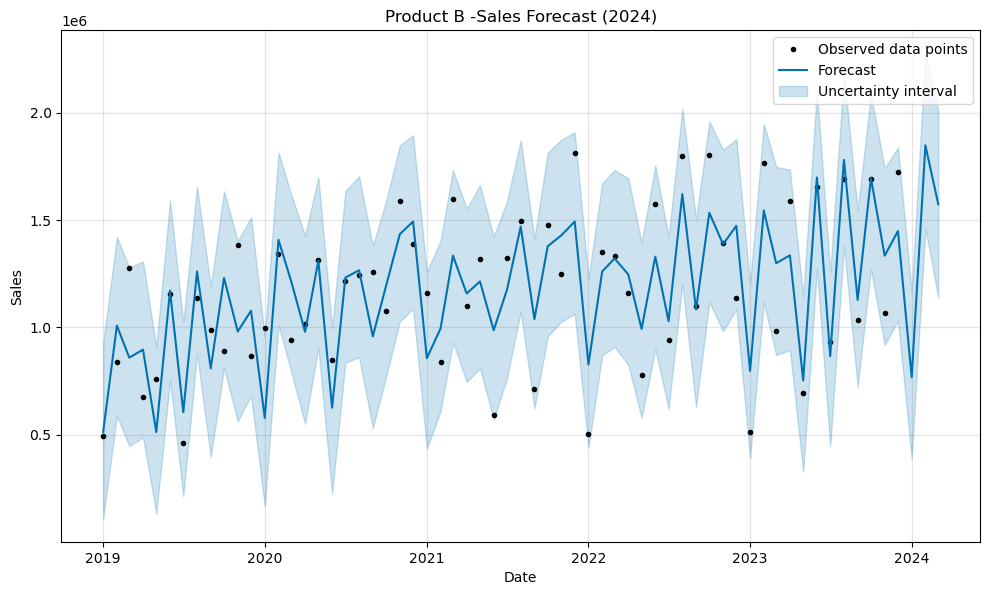

In [41]:
fig = model_forecast.plot(forecast_f, include_legend=True, uncertainty=True)
plt.title('Product B -Sales Forecast (2024)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

In [42]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(model_forecast,forecast_f)

In [43]:
plot_components_plotly(model_forecast, forecast_f)